<a href="https://colab.research.google.com/github/leemordechai/pandas_exercises/blob/master/ABM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install mesa

In [0]:
import pandas as pd
import mesa
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#@title
from mesa import Agent, Model
from mesa.time import RandomActivation

class MoneyAgent(Agent):
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.wealth = 1
    
  def step(self):
    if self.wealth == 0:
      return
    other_agent = random.choice(self.model.schedule.agents)
    other_agent.wealth += 1
    self.wealth -= 1    

class MoneyModel(Model):
  def __init__(self, N):
    self.num_agents = N
    self.schedule = RandomActivation(self)
    for i in range(self.num_agents):
      a = MoneyAgent(i, self)
      self.schedule.add(a)
      
  def step(self):
    self.schedule.step()

In [0]:
#@title
model = MoneyModel(10)
for i in range(10):
  model.step()

(array([4., 0., 0., 3., 0., 0., 2., 0., 0., 1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

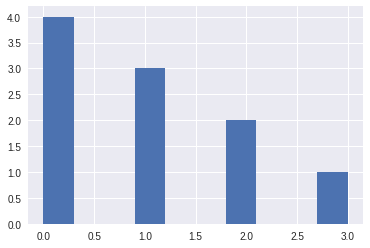

In [7]:
#@title
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

(array([4.1575e+04, 3.1793e+04, 1.6412e+04, 6.7780e+03, 2.4710e+03,
        7.2000e+02, 2.0000e+02, 4.4000e+01, 7.0000e+00]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

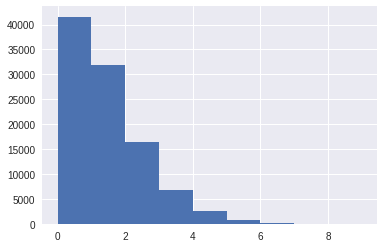

In [8]:
#@title
all_wealth = []
for j in range(1000):
  model = MoneyModel(10)
  for i in range(10):
    model.step()
    
    for agent in model.schedule.agents:
      all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))

In [0]:
#@title
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

class MoneyModel(Model):
  def __init__(self, N, width, height):
    self.num_agents = N
    self.grid = MultiGrid(width, height, True) # True here refers to wrap
    self.schedule = RandomActivation(self)
    self.running = True #this is for batch running

    for i in range(self.num_agents):
      a = MoneyAgent(i, self)
      self.schedule.add(a)

      x = random.randrange(self.grid.width)
      y = random.randrange(self.grid.height)
      self.grid.place_agent(a, (x, y))
      
    self.datacollector = DataCollector(model_reporters={"Gini": compute_gini},
                                      agent_reporters={"Wealth":"wealth"})
    
  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()  
    

class MoneyAgent(Agent):
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.wealth = 1
    
  def step(self):
    self.move()
    if self.wealth > 0:
      self.give_money()
  
  def move(self):
    possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
    # Moore=True includes diagonal movement
    new_position = random.choice(possible_steps)
    self.model.grid.move_agent(self, new_position)
  
  def give_money(self):
    cellmates = self.model.grid.get_cell_list_contents([self.pos])
    if len(cellmates) > 1:
      other = random.choice(cellmates)
      other.wealth += 1
      self.wealth -= 1
      #print(str(self.unique_id) + " gave money to " + str(other.unique_id))
      
  #calculate Gini
def compute_gini(model): 
  agent_wealths = [agent.wealth for agent in model.schedule.agents]
  x = sorted(agent_wealths)
  N = model.num_agents
  B = sum(xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
  return (1+(1/N)-2*B)

In [0]:
#@title
model = MoneyModel(50, 10, 10)
for i in range(100):
  model.step()

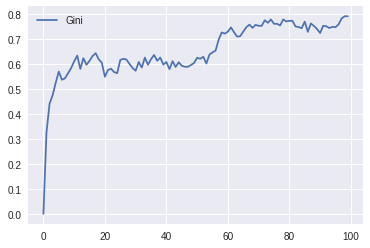

In [11]:
#@title
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [143]:
#@title
model.datacollector.get_agent_vars_dataframe().head()
agent_wealth = model.datacollector.get_agent_vars_dataframe()

AttributeError: ignored

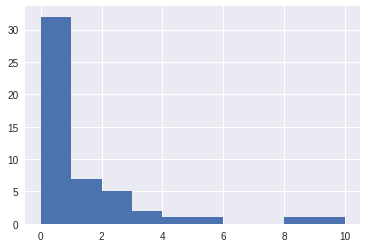

In [13]:
#@title
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

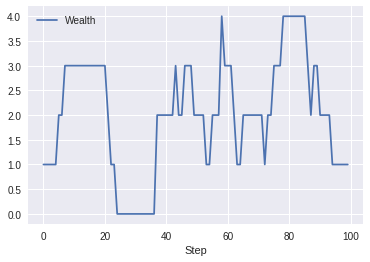

In [14]:
#@title
one_agent_wealth = agent_wealth.xs(1,level="AgentID")
one_agent_wealth.plot()

In [0]:
#@title
from mesa.batchrunner import BatchRunner

fixed_params = {"width": 10,
                "height": 10}
variable_params = {"N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
#batch_run.run_all()

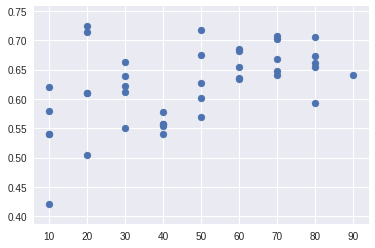

In [16]:
#@title
run_data = batch_run.get_model_vars_dataframe() #returns a df
#run_data.head()
plt.scatter(run_data.N, run_data.Gini) # scatterplot of two columns in it

In [0]:
#@title


In [0]:
#@title
model = MoneyModel(9, 3, 3)
for i in range(1):
  model.step()

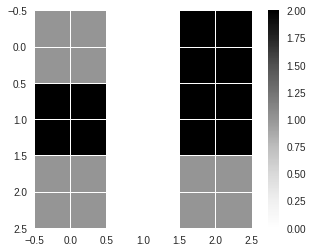

In [18]:
#@title
import numpy as np
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
  cell_content, x, y = cell
  agent_count = len(cell_content)
  agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

In [0]:
from mesa import Agent, Model # for basics
from mesa.time import SimultaneousActivation # scheduler
from mesa.space import SingleGrid # for grid
from mesa.datacollection import DataCollector # for collecting data
import time

class LifeModel(Model):
  def __init__(self, N, width, height):
    self.running = True
    self.num_agents = N
    self.width = width
    self.height = height
    self.grid = SingleGrid(width, height, True)
    self.schedule = SimultaneousActivation(self)
    self.num_alive = N
    self.avg_age = N / (width * height)
    self.avg_living_age = 1
    
    for i in range(self.num_agents):
      a = CellAgent(i, True, self)
      a.current_fate = 'birth'
      self.grid.place_agent(a, self.grid.find_empty())
      self.schedule.add(a)
    
    i = self.num_agents
    while self.grid.exists_empty_cells() == True:
      a = CellAgent(i, False, self)
      i += 1
      self.grid.place_agent(a, self.grid.find_empty())
      a.current_fate = 'death'
      self.schedule.add(a)
      
  def step(self):
    self.schedule.step()
  
  def advance(self):
    self.schedule.advance()
    
  def alive_cells(self, feedback=False):
    counter = 0
    total_age = 0
    for i in range(self.height):
      for j in range(self.width):
        if self.grid[i][j].alive == True: 
          counter += 1
          total_age = self.grid[i][j].age
    self.avg_age = total_age / (self.height * self.width)
    if counter > 0:
      self.avg_living_age = total_age / counter
    else: self.avg_living_age = 0
      
    if feedback == True:
      print('Number alive: ' + str(counter))
    self.num_alive = counter
    return self.num_alive
  
  def get_avg_age(self):
    return self.avg_age
  
  def get_avg_living_age(self):
    return self.avg_living_age
         
    
class CellAgent(Agent):
  def __init__(self, unique_id, alive, model):
    self.unique_id = unique_id
    self.model = model
    self.alive = alive
    self.current_fate = ''
    if alive == True:
      self.age = 1
    else: self.age = 0
  
  def advance(self):
    if self.current_fate == 'death': 
      self.alive = False
      self.age = 0
    elif self.current_fate == 'survival':
      self.alive = True
      self.age += 1
    else: # == 'birth'
      self.alive = True
      self.age = 1    
    #print(self.current_fate, self.alive)
    
  def step(self):
    neighbors = self.model.grid.iter_neighbors(self.pos, True)
    living_neighbors = sum([1 for i in neighbors if i.alive == True])
    if self.alive == True:
      if (living_neighbors > 3) or (living_neighbors < 2):
        self.current_fate = 'death'
      else:
        self.current_fate = 'survival'        
    elif living_neighbors == 3:
      self.current_fate = 'birth'
    #print(living_neighbors, self.current_fate, self.alive)

In [0]:
def vis_model(m, secs=1):
  hei = m.height
  wid = m.width
  df = [[0] * hei for i in range(wid)]
  #pd.DataFrame(data=[[None for x in range(hei)] for x in range(wid)], columns=range(wid))
  for i in range(hei):
    for j in range(wid):
      try:
        df[i][j] = m.grid[i][j].alive
      except:
        print(i, j)
  
  fig = plt.figure()
  ax = fig.gca()
  ax.grid(False)
  plt.imshow(df, interpolation='nearest')

20

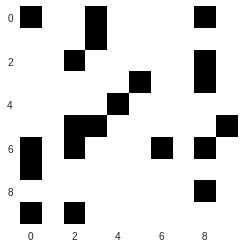

In [113]:
model = LifeModel(20,10,10)
vis_model(model)
model.alive_cells()

21

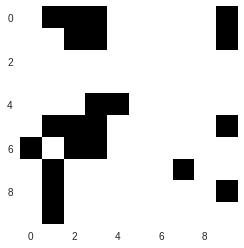

In [114]:
model.alive_cells()
model.step()
vis_model(model)
model.alive_cells()

In [115]:
generations = 100
iterations = 5

df = pd.DataFrame(index=range(generations))
df_avg_ages = pd.DataFrame(index=range(generations))
df_avg_living_ages = pd.DataFrame(index=range(generations))
for i in range(iterations):
  model = LifeModel(30,10,10)
  survivors = [model.alive_cells()]
  average_ages = [model.get_avg_age()]
  average_living_ages = [model.get_avg_living_age()]
  
  for j in range(generations-1):
    model.step()
    survivors.append(model.alive_cells())
    average_ages.append(model.get_avg_age())
    average_living_ages.append(model.get_avg_living_age())
                        
  df[i] = survivors
  df_avg_ages[i] = average_ages       
  df_avg_living_ages[i] = average_living_ages
                        
  if i%10 == 0: print("Iteration " + str(i))
df.head(2)

Iteration 0


,0,1,2,3,4
0,30,30,30,30,30
1,33,31,33,43,36


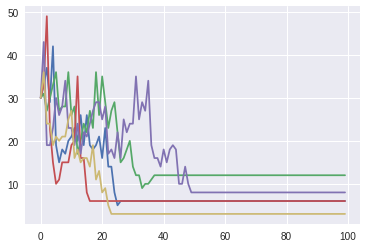

In [116]:
for col in df.columns:
  plt.plot(range(generations), df[col])

#for col in df_avg_living_ages.columns:
#  plt.plot(range(generations), df_avg_living_ages[col])
  
#for col in df_avg_ages.columns:
#  plt.plot(range(generations), df_avg_ages[col])

In [141]:
from mesa.batchrunner import BatchRunner

generations = 10
iterations = 20

fixed_params = {"width": 10, "height": 10}
variable_params = {"N": range(10, 80)}

batch_run = BatchRunner(LifeModel,
                       fixed_parameters = fixed_params,
                       variable_parameters = variable_params,
                       iterations = iterations,
                       max_steps = generations,
                       model_reporters= {"Survivors":LifeModel.alive_cells})

batch_run.run_all()
run_data = batch_run.get_model_vars_dataframe()
run_data.head(2)

1400it [00:40, 34.92it/s]


,N,Run,Survivors,width,height
0,10,0,3,10,10
1,10,1,0,10,10
2,10,2,0,10,10
3,10,3,36,10,10
4,10,4,0,10,10


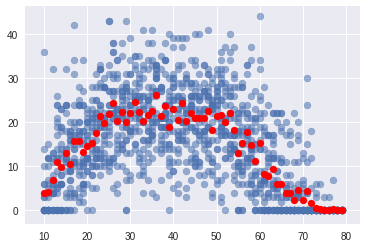

In [142]:
# optimal number for survival in Life environments
plt.scatter(run_data.N, run_data.Survivors, alpha=0.55)
line_data = run_data.groupby(['N']).mean()
plt.scatter(line_data.index, line_data['Survivors'], c='r')